xgboost / gbm / light gmb

In [8]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 
import missingno as msno

import sqlite3 as sql 

import pingouin as pg
from random import sample

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
pd.set_option('display.max_columns', None)

- We have 4 kinds of variable sets 
    - variable set 1: player attributes PC features
    - Variable set 2: betting information features
    - variable set 3: team attributes features
    - variable set 4: goal and win percentage rolling features

- By using each variable sets, let's predict the match result and compare the result.

In [53]:
df_match_player_attr_pcs = pd.read_csv("../data/df_match_player_attr_pcs.csv")

In [25]:
df_match_betting_stat = pd.read_csv("../data/df_match_betting_stat.csv")

In [150]:
df_match_team_num_attr = pd.read_csv("../data/df_match_team_num_attr.csv")

In [27]:
df_team_win_goal_rolling_features = pd.read_csv("../data/df_team_win_goal_rolling_features.csv")

# 0. Train test split

- Set last season as test set, other seasons as train set.

In [31]:
df_match_basic = pd.read_csv("../data/df_match_basic.csv")

In [34]:
target_bool = (df_match_basic.match_api_id.isin(df_match_player_attr_pcs.match_api_id)) & \
              (df_match_basic.match_api_id.isin(df_match_betting_stat.match_api_id)) & \
              (df_match_basic.match_api_id.isin(df_match_team_num_attr.match_api_id)) & \
              (df_match_basic.match_api_id.isin(df_team_win_goal_rolling_features.match_api_id)) 
    

In [36]:
target_matches = df_match_basic[target_bool]

In [62]:
test_match_api_id = target_matches[target_matches.season == "2015/2016"].match_api_id
train_match_api_id = target_matches[target_matches.season != "2015/2016"].match_api_id

In [63]:
print(len(train_match_api_id), len(test_match_api_id))

17029 2662


# 1. Variable set 1: Player attributes PC features

In [54]:
df_match_player_attr_pcs = df_match_player_attr_pcs.merge(df_match_basic[["match_api_id", "match_result"]], how = "left", on = "match_api_id")

In [55]:
df_match_player_attr_pcs = df_match_player_attr_pcs.set_index("match_api_id")
df_match_player_attr_pcs


,home_player_1_pc_1,home_player_1_pc_2,home_player_1_pc_3,home_player_1_pc_4,home_player_1_pc_5,home_player_2_pc_1,home_player_2_pc_2,home_player_2_pc_3,home_player_2_pc_4,home_player_2_pc_5,home_player_3_pc_1,home_player_3_pc_2,home_player_3_pc_3,home_player_3_pc_4,home_player_3_pc_5,home_player_4_pc_1,home_player_4_pc_2,home_player_4_pc_3,home_player_4_pc_4,home_player_4_pc_5,home_player_5_pc_1,home_player_5_pc_2,home_player_5_pc_3,home_player_5_pc_4,home_player_5_pc_5,home_player_6_pc_1,home_player_6_pc_2,home_player_6_pc_3,home_player_6_pc_4,home_player_6_pc_5,home_player_7_pc_1,home_player_7_pc_2,home_player_7_pc_3,home_player_7_pc_4,home_player_7_pc_5,home_player_8_pc_1,home_player_8_pc_2,home_player_8_pc_3,home_player_8_pc_4,home_player_8_pc_5,home_player_9_pc_1,home_player_9_pc_2,home_player_9_pc_3,home_player_9_pc_4,home_player_9_pc_5,home_player_10_pc_1,home_player_10_pc_2,home_player_10_pc_3,home_player_10_pc_4,home_player_10_pc_5,home_player_11_pc_1,home_player_11_pc_2,home_player_11_pc_3,home_player_11_pc_4,home_player_11_pc_5,away_player_1_pc_1,away_player_1_pc_2,away_player_1_pc_3,away_player_1_pc_4,away_player_1_pc_5,away_player_2_pc_1,away_player_2_pc_2,away_player_2_pc_3,away_player_2_pc_4,away_player_2_pc_5,away_player_3_pc_1,away_player_3_pc_2,away_player_3_pc_3,away_player_3_pc_4,away_player_3_pc_5,away_player_4_pc_1,away_player_4_pc_2,away_player_4_pc_3,away_player_4_pc_4,away_player_4_pc_5,away_player_5_pc_1,away_player_5_pc_2,away_player_5_pc_3,away_player_5_pc_4,away_player_5_pc_5,away_player_6_pc_1,away_player_6_pc_2,away_player_6_pc_3,away_player_6_pc_4,away_player_6_pc_5,away_player_7_pc_1,away_player_7_pc_2,away_player_7_pc_3,away_player_7_pc_4,away_player_7_pc_5,away_player_8_pc_1,away_player_8_pc_2,away_player_8_pc_3,away_player_8_pc_4,away_player_8_pc_5,away_player_9_pc_1,away_player_9_pc_2,away_player_9_pc_3,away_player_9_pc_4,away_player_9_pc_5,away_player_10_pc_1,away_player_10_pc_2,away_player_10_pc_3,away_player_10_pc_4,away_player_10_pc_5,away_player_11_pc_1,away_player_11_pc_2,away_player_11_pc_3,away_player_11_pc_4,away_player_11_pc_5,match_result
match_api_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
493017,9.172915,-0.705596,1.028500,-0.044401,1.246272,3.957784,1.650964,-2.348632,-0.837480,0.223750,-0.817702,-0.589548,0.195433,-2.144582,1.524434,3.108730,0.633708,-1.772338,0.807727,1.684577,0.615229,-0.611994,-0.845425,0.395221,3.107710,-0.038702,-0.551509,-0.280096,-0.068082,2.645878,1.086047,-2.583583,-0.596348,-1.915882,-0.987251,-0.845848,-0.053597,0.746034,-0.515174,1.763346,4.244623,1.088030,-2.054898,-0.414998,0.270225,-0.559441,1.233335,0.426201,0.609910,1.364324,1.472274,-0.298277,-1.530989,0.743621,-0.875547,9.794795,-0.549117,1.941560,0.281992,0.521328,-1.886782,1.005850,1.291888,0.172012,1.212622,1.320201,1.065244,-0.406996,-1.803778,0.573483,2.628391,0.940615,-0.609534,-1.586848,0.652795,3.207876,0.685128,-1.480756,-1.499414,0.134771,-1.360311,-2.979972,1.181522,-0.726996,1.161218,-1.735000,-0.323721,0.977427,-1.047350,1.307837,-0.004187,1.646099,0.543917,0.101722,0.374692,-1.836650,-2.551881,1.212316,0.139711,1.155972,-0.916797,-1.202214,0.022668,-0.118531,-0.332637,0.628660,-1.751083,-0.030693,0.418133,-0.206630,home_win
493025,6.467731,-2.125163,3.092089,-0.930974,1.172527,0.390653,1.341612,0.109198,-0.418330,0.921304,2.673401,1.688787,-0.346764,0.032250,-0.148238,0.544724,0.856618,-0.234054,-0.185530,1.496783,0.349558,-0.322471,0.311433,-0.720916,0.765089,-2.997770,-1.279240,1.492689,-0.174247,1.728035,-1.262416,0.290702,1.097804,0.377514,1.681666,-1.035827,-0.034337,1.133088,0.899750,1.451945,-1.970162,-1.958911,1.072887,0.806278,2.735079,-1.206227,-2.567254,0.401355,-0.240084,1.552955,-0.417405,-0.845298,0.077456,-1.026087,-0.249720,6.746068,-1.225452,5.441467,-1.741143,0.153029,-0.720625,1.362837,0.950063,-0.430052,1.920381,1.321520,2.234319,0.546943,0.392576,1.081937,-1.157135,1.181325,0.901247,0.

In [69]:
train_match_api_id

145       493017
153       493025
155       493027
162       493034
168       493040
          ...   
24172    1778119
24173    1778120
24174    1778121
24175    1778122
24176    1778123
Name: match_api_id, Length: 17029, dtype: int64

In [70]:
train_bool = df_match_player_attr_pcs.reset_index().match_api_id.isin(train_match_api_id)
test_bool = df_match_player_attr_pcs.reset_index().match_api_id.isin(test_match_api_id) 

In [77]:
df_pc_train = df_match_player_attr_pcs.reset_index()[train_bool].set_index("match_api_id")
df_pc_test = df_match_player_attr_pcs.reset_index()[test_bool].set_index("match_api_id")

In [78]:
X_pc_train = df_pc_train.drop("match_result", axis = 1)
y_pc_train = df_pc_train.match_result 

X_pc_test = df_pc_test.drop("match_result", axis = 1)
y_pc_test = df_pc_test.match_result

In [79]:
print("Number of train data: ", X_pc_train.shape[0])
print("Number of test data: ", X_pc_test.shape[0])

Number of train data:  17029
Number of test data:  2662


In [83]:
names = ["KNN", 
         "LDA", 
         "QDA", 
         "Naive Bayes",
         "Logistic regression",
         "Decesion tree", 
         "Random Forest",  
         "AdaBoost",
         "Polynomial kernel SVM",
         "Radial kernel SVM",
         "GBM"
        ]

classifiers = [
    KNeighborsClassifier(3),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(), 
    LogisticRegression(),
    DecisionTreeClassifier(random_state = 42),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    SVC(kernel = "poly"),
    SVC(kernel = "rbf"),
    GradientBoostingClassifier()
    ]

In [85]:
result_accuracy = pd.DataFrame(names, columns = ["model_name"])

In [86]:
y_pred_dict = {}

for name, clf in zip(names, classifiers):
    clf.fit(X_pc_train, y_pc_train)
    
    y_pred = clf.predict(X_pc_test)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_pc_test)
    
    result_accuracy.loc[result_accuracy.model_name == name, "Player PC Variables"] = round(accuracy * 100, 3)

In [87]:
result_accuracy

,model_name,Player PC Variables
0,KNN,41.134
1,LDA,50.075
2,QDA,42.637
3,Naive Bayes,46.920
4,Logistic regression,50.225
5,Decesion tree,38.467
6,Random Forest,49.775
7,AdaBoost,49.624
8,Polynomial kernel SVM,50.413
9,Radial kernel SVM,50.864


# 2. Variable set 2: Betting information features

In [94]:
df_match_betting_stat = df_match_betting_stat.merge(df_match_basic[["match_api_id", "match_result"]], how = "left", on = "match_api_id")

In [95]:
train_bool = df_match_betting_stat.match_api_id.isin(train_match_api_id)
test_bool = df_match_betting_stat.match_api_id.isin(test_match_api_id) 

In [96]:
df_bet_train = df_match_betting_stat[train_bool].set_index("match_api_id")
df_bet_test = df_match_betting_stat[test_bool].set_index("match_api_id")

In [97]:
X_bet_train = df_bet_train.drop("match_result", axis = 1)
y_bet_train = df_bet_train.match_result 

X_bet_test = df_bet_test.drop("match_result", axis = 1)
y_bet_test = df_bet_test.match_result

In [98]:
print("Number of train data: ", X_bet_train.shape[0])
print("Number of test data: ", X_bet_test.shape[0])

Number of train data:  17029
Number of test data:  2662


In [99]:
for name, clf in zip(names, classifiers):
    clf.fit(X_bet_train, y_bet_train)
    
    y_pred = clf.predict(X_bet_test)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_bet_test)
    
    result_accuracy.loc[result_accuracy.model_name == name, "Betting Statistics Variables"] = round(accuracy * 100, 3)

In [100]:
result_accuracy

,model_name,Player PC Variables,Betting Statistics Variables
0,KNN,41.134,45.304
1,LDA,50.075,51.503
2,QDA,42.637,33.959
3,Naive Bayes,46.920,41.998
4,Logistic regression,50.225,51.728
5,Decesion tree,38.467,42.299
6,Random Forest,49.775,48.009
7,AdaBoost,49.624,51.653
8,Polynomial kernel SVM,50.413,51.014
9,Radial kernel SVM,50.864,51.427


# 3. Variable set 3: Team attribute features

In [151]:
df_match_team_num_attr = df_match_team_num_attr.merge(df_match_basic[["match_api_id", "match_result"]], how = "left", on = "match_api_id")

In [152]:
train_bool = df_match_team_num_attr.match_api_id.isin(train_match_api_id)
test_bool = df_match_team_num_attr.match_api_id.isin(test_match_api_id) 

In [153]:
df_team_train = df_match_team_num_attr[train_bool].set_index("match_api_id")
df_team_test = df_match_team_num_attr[test_bool].set_index("match_api_id")

In [154]:
X_team_train = df_team_train.drop("match_result", axis = 1)
y_team_train = df_team_train.match_result 

X_team_test = df_team_test.drop("match_result", axis = 1)
y_team_test = df_team_test.match_result

In [155]:
print("Number of train data: ", X_team_train.shape[0])
print("Number of test data: ", X_team_test.shape[0])

Number of train data:  17029
Number of test data:  2662


In [156]:
X_team_train.fillna(0, inplace = True)
X_team_test.fillna(0, inplace = True)

In [157]:
for name, clf in zip(names, classifiers):
    clf.fit(X_team_train, y_team_train)
    
    y_pred = clf.predict(X_team_test)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_team_test)
    
    result_accuracy.loc[result_accuracy.model_name == name, "Team attribute Variables"] = round(accuracy * 100, 3)

In [158]:
result_accuracy

,model_name,Player PC Variables,Betting Statistics Variables,Team attribute Variables,Team's goal and win percentage rolling Variables
0,KNN,41.134,45.304,38.881,40.909
1,LDA,50.075,51.503,45.680,49.850
2,QDA,42.637,33.959,45.605,45.417
3,Naive Bayes,46.920,41.998,46.319,47.220
4,Logistic regression,50.225,51.728,45.642,50.301
5,Decesion tree,38.467,42.299,37.716,40.947
6,Random Forest,49.775,48.009,44.591,48.573
7,AdaBoost,49.624,51.653,47.333,50.301
8,Polynomial kernel SVM,50.413,51.014,45.192,50.000
9,Radial kernel SVM,50.864,51.427,45.004,49.699


# 4. Variable set 4: Goal and win percentage rolling features

In [116]:
df_team_win_goal_rolling_features = df_team_win_goal_rolling_features.merge(df_match_basic[["match_api_id", "match_result"]], how = "left", on = "match_api_id")

In [117]:
train_bool = df_team_win_goal_rolling_features.reset_index().match_api_id.isin(train_match_api_id)
test_bool = df_team_win_goal_rolling_features.reset_index().match_api_id.isin(test_match_api_id) 

In [118]:
df_rolling_train = df_team_win_goal_rolling_features[train_bool].set_index("match_api_id")
df_rolling_test = df_team_win_goal_rolling_features[test_bool].set_index("match_api_id")

In [119]:
X_rolling_train = df_rolling_train.drop("match_result", axis = 1)
y_rolling_train = df_rolling_train.match_result 

X_rolling_test = df_rolling_test.drop("match_result", axis = 1)
y_rolling_test = df_rolling_test.match_result

In [120]:
print("Number of train data: ", X_rolling_train.shape[0])
print("Number of test data: ", X_rolling_test.shape[0])

Number of train data:  17029
Number of test data:  2662


In [126]:
X_rolling_train.fillna(0, inplace = True)
X_rolling_test.fillna(0, inplace = True)

In [127]:
for name, clf in zip(names, classifiers):
    clf.fit(X_rolling_train, y_rolling_train)
    
    y_pred = clf.predict(X_rolling_test)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_rolling_test)
    
    result_accuracy.loc[result_accuracy.model_name == name, "Team's goal and win percentage rolling Variables"] = round(accuracy * 100, 3)

In [128]:
result_accuracy

,model_name,Player PC Variables,Betting Statistics Variables,Team attribute Variables,Team's goal and win percentage rolling Variables
0,KNN,41.134,45.304,38.881,40.909
1,LDA,50.075,51.503,45.455,49.850
2,QDA,42.637,33.959,45.567,45.417
3,Naive Bayes,46.920,41.998,46.168,47.220
4,Logistic regression,50.225,51.728,45.680,50.301
5,Decesion tree,38.467,42.299,37.716,40.947
6,Random Forest,49.775,48.009,45.379,48.573
7,AdaBoost,49.624,51.653,47.333,50.301
8,Polynomial kernel SVM,50.413,51.014,44.515,50.000
9,Radial kernel SVM,50.864,51.427,44.515,49.699


# 5. Use all variables

In [159]:
df_all = df_match_player_attr_pcs.merge(df_match_betting_stat.drop("match_result", axis = 1), how = "left", on = ["match_api_id"]) \
                                 .merge(df_match_team_num_attr.drop("match_result", axis = 1), how = "left", on = ["match_api_id"]) \
                                 .merge(df_team_win_goal_rolling_features.drop("match_result", axis = 1), how = "left", on = ["match_api_id"]) 
                                 

In [160]:
train_bool = df_all.match_api_id.isin(train_match_api_id)
test_bool = df_all.match_api_id.isin(test_match_api_id) 

In [161]:
df_all_train = df_all[train_bool].set_index("match_api_id")
df_all_test = df_all[test_bool].set_index("match_api_id")

In [162]:
X_all_train = df_all_train.drop("match_result", axis = 1)
y_all_train = df_all_train.match_result 

X_all_test = df_all_test.drop("match_result", axis = 1)
y_all_test = df_all_test.match_result

In [163]:
print("Number of train data: ", X_all_train.shape[0])
print("Number of test data: ", X_all_test.shape[0])

Number of train data:  17029
Number of test data:  2662


In [164]:
X_all_train.fillna(0, inplace = True)
X_all_test.fillna(0, inplace = True)

In [233]:
scalter = StandardScaler()
scalter.fit(X_all_train)
X_all_train_std = scalter.transform(X_all_train)
X_all_test_std = scalter.transform(X_all_test)


In [234]:
for name, clf in zip(names, classifiers):
    clf.fit(X_all_train_std, y_all_train)
    
    y_pred = clf.predict(X_all_test_std)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_all_test)
    
    result_accuracy.loc[result_accuracy.model_name == name, "All Variables std"] = round(accuracy * 100, 3)

In [235]:
result_accuracy

,model_name,Player PC Variables,Betting Statistics Variables,Team attribute Variables,Team's goal and win percentage rolling Variables,All Variables,Baseline accuracy,All Variables std
0,KNN,41.134,45.304,38.881,40.909,41.773,0.443651,43.576
1,LDA,50.075,51.503,45.680,49.850,50.789,0.443651,50.789
2,QDA,42.637,33.959,45.605,45.417,43.050,0.443651,44.591
3,Naive Bayes,46.920,41.998,46.319,47.220,46.243,0.443651,46.243
4,Logistic regression,50.225,51.728,45.642,50.301,51.390,0.443651,51.728
5,Decesion tree,38.467,42.299,37.716,40.947,40.759,0.443651,40.721
6,Random Forest,49.775,48.009,44.591,48.573,50.488,0.443651,50.413
7,AdaBoost,49.624,51.653,47.333,50.301,51.277,0.443651,51.277
8,Polynomial kernel SVM,50.413,51.014,45.192,50.000,50.826,0.443651,48.911
9,Radial kernel SVM,50.864,51.427,45.004,49.699,51.165,0.443651,51.127


In [165]:
for name, clf in zip(names, classifiers):
    clf.fit(X_all_train, y_all_train)
    
    y_pred = clf.predict(X_all_test)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_all_test)
    
    result_accuracy.loc[result_accuracy.model_name == name, "All Variables"] = round(accuracy * 100, 3)

In [167]:
temp = result_accuracy

In [174]:
baseline_accuracy = np.mean("home_win" == y_all_test)

In [175]:
baseline_accuracy

0.4436513899323817

In [176]:
temp["Baseline accuracy"] = baseline_accuracy

In [177]:
temp.columns

Index(['model_name', 'Player PC Variables', 'Betting Statistics Variables',
       'Team attribute Variables',
       'Team's goal and win percentage rolling Variables', 'All Variables',
       'Baseline accuracy'],
      dtype='object')

In [186]:
temp[["Player PC Variables"]].iloc[:, 0]

0     41.134
1     50.075
2     42.637
3     46.920
4     50.225
5     38.467
6     49.775
7     49.624
8     50.413
9     50.864
10    50.150
Name: Player PC Variables, dtype: float64

In [196]:
temp = temp[['model_name', "Baseline accuracy", 'Player PC Variables', 'Betting Statistics Variables',
       'Team attribute Variables',
       "Team's goal and win percentage rolling Variables", "All Variables"]]

In [197]:
temp

,model_name,Baseline accuracy,Player PC Variables,Betting Statistics Variables,Team attribute Variables,Team's goal and win percentage rolling Variables,All Variables
0,KNN,0.443651,41.134,45.304,38.881,40.909,41.773
1,LDA,0.443651,50.075,51.503,45.680,49.850,50.789
2,QDA,0.443651,42.637,33.959,45.605,45.417,43.050
3,Naive Bayes,0.443651,46.920,41.998,46.319,47.220,46.243
4,Logistic regression,0.443651,50.225,51.728,45.642,50.301,51.390
5,Decesion tree,0.443651,38.467,42.299,37.716,40.947,40.759
6,Random Forest,0.443651,49.775,48.009,44.591,48.573,50.488
7,AdaBoost,0.443651,49.624,51.653,47.333,50.301,51.277
8,Polynomial kernel SVM,0.443651,50.413,51.014,45.192,50.000,50.826
9,Radial kernel SVM,0.443651,50.864,51.427,45.004,49.699,51.165


In [210]:
temp_avg = pd.DataFrame(["Average", 0.443651, 47.298545, 47.336091, 44.498545, 47.527636, 48.138727]).transpose()
temp_avg

,0,1,2,3,4,5,6
0,Average,0.443651,47.298545,47.336091,44.498545,47.527636,48.138727


In [211]:
temp_avg.columns = temp.columns

In [212]:
temp_avg

,model_name,Baseline accuracy,Player PC Variables,Betting Statistics Variables,Team attribute Variables,Team's goal and win percentage rolling Variables,All Variables
0,Average,0.443651,47.298545,47.336091,44.498545,47.527636,48.138727


In [221]:
temp_merged = pd.concat([temp, temp_avg], axis = 0)

In [225]:
np.round(temp_merged, 0)

,model_name,Baseline accuracy,Player PC Variables,Betting Statistics Variables,Team attribute Variables,Team's goal and win percentage rolling Variables,All Variables
0,KNN,0.443651,41.134,45.304,38.881,40.909,41.773
1,LDA,0.443651,50.075,51.503,45.68,49.85,50.789
2,QDA,0.443651,42.637,33.959,45.605,45.417,43.05
3,Naive Bayes,0.443651,46.92,41.998,46.319,47.22,46.243
4,Logistic regression,0.443651,50.225,51.728,45.642,50.301,51.39
5,Decesion tree,0.443651,38.467,42.299,37.716,40.947,40.759
6,Random Forest,0.443651,49.775,48.009,44.591,48.573,50.488
7,AdaBoost,0.443651,49.624,51.653,47.333,50.301,51.277
8,Polynomial kernel SVM,0.443651,50.413,51.014,45.192,50.0,50.826
9,Radial kernel SVM,0.443651,50.864,51.427,45.004,49.699,51.165


In [229]:
temp_merged

,model_name,Baseline accuracy,Player PC Variables,Betting Statistics Variables,Team attribute Variables,Team's goal and win percentage rolling Variables,All Variables
0,KNN,0.443651,41.134,45.304,38.881,40.909,41.773
1,LDA,0.443651,50.075,51.503,45.68,49.85,50.789
2,QDA,0.443651,42.637,33.959,45.605,45.417,43.05
3,Naive Bayes,0.443651,46.92,41.998,46.319,47.22,46.243
4,Logistic regression,0.443651,50.225,51.728,45.642,50.301,51.39
5,Decesion tree,0.443651,38.467,42.299,37.716,40.947,40.759
6,Random Forest,0.443651,49.775,48.009,44.591,48.573,50.488
7,AdaBoost,0.443651,49.624,51.653,47.333,50.301,51.277
8,Polynomial kernel SVM,0.443651,50.413,51.014,45.192,50.0,50.826
9,Radial kernel SVM,0.443651,50.864,51.427,45.004,49.699,51.165


In [232]:
temp_merged.drop("Baseline accuracy", axis = 1).groupby("model_name")

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
0    NaN
dtype: float64

In [ ]:
y_test

In [ ]:
The baseline accuracy is achieved by predicting the match result just as home team win.

In [ ]:
11 models and 4 variable set combinations

In [ ]:
df

In [236]:
param_grid = [{
     'penalty' : ['l1', 'l2'],
     'C' : np.logspace(-4, 4, 20),
}]


In [237]:
model = LogisticRegression()

log_grid = GridSearchCV(model, param_grid, cv = 5, n_jobs = -1)
log_grid.fit(X_all_train_std, y_all_train)


/Users/youngjun/anaconda3/envs/data_analysis_venv/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/youngjun/anaconda3/envs/data_analysis_venv/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/youngjun/anaconda3/envs/data_analysis_venv/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegressi

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2']}])

In [239]:
print(log_grid.best_params_)


{'C': 0.0001, 'penalty': 'l2'}


In [238]:
print(log_grid.best_estimator_)
print(log_grid.best_score_)

LogisticRegression(C=0.0001)
0.5297437794407899


In [240]:
y_pred = log_grid.predict(X_all_test_std)

In [241]:
np.mean(y_pred != y_all_test)

0.4861006761833208

In [242]:
final_model = LogisticRegression(penalty = log_grid.best_params_["penalty"], C = log_grid.best_params_["C"])
final_model.fit(X_all_train_std, y_all_train)


LogisticRegression(C=0.0001)

In [254]:
coeff = pd.DataFrame({"column_name": X_all_train.columns, "coef": final_model.coef_[0]})

In [258]:
coeff

,column_name,coef
0,home_player_1_pc_1,0.004586
1,home_player_1_pc_2,0.000164
2,home_player_1_pc_3,-0.007375
3,home_player_1_pc_4,0.005856
4,home_player_1_pc_5,0.000052
...,...,...
197,away_team_away_lose_percentage_last_30_matches,-0.006523
198,away_team_away_win_percentage_last_60_matches,0.008797
199,away_team_away_lose_percentage_last_60_matches,0.000493
200,away_team_away_win_percentage_last_90_matches,0.005519


In [270]:
coeff["coef_abs"] = np.abs(coeff.coef)

In [271]:
coeff

,column_name,coef,coef_abs
0,home_player_1_pc_1,0.004586,0.004586
1,home_player_1_pc_2,0.000164,0.000164
2,home_player_1_pc_3,-0.007375,0.007375
3,home_player_1_pc_4,0.005856,0.005856
4,home_player_1_pc_5,0.000052,0.000052
...,...,...,...
197,away_team_away_lose_percentage_last_30_matches,-0.006523,0.006523
198,away_team_away_win_percentage_last_60_matches,0.008797,0.008797
199,away_team_away_lose_percentage_last_60_matches,0.000493,0.000493
200,away_team_away_win_percentage_last_90_matches,0.005519,0.005519


In [278]:
coeff.sort_values("coef_abs", ascending = False).iloc[21:, :].head(20)

,column_name,coef,coef_abs
45,home_player_10_pc_1,0.012605,0.012605
27,home_player_6_pc_3,-0.012578,0.012578
30,home_player_7_pc_1,0.012565,0.012565
75,away_player_5_pc_1,-0.012248,0.012248
77,away_player_5_pc_3,0.012142,0.012142
15,home_player_4_pc_1,0.011918,0.011918
97,away_player_9_pc_3,0.011870,0.011870
70,away_player_4_pc_1,-0.011756,0.011756
93,away_player_8_pc_4,-0.011704,0.011704
87,away_player_7_pc_3,0.011635,0.011635


In [291]:
coeff["coef"] = -coeff.coef

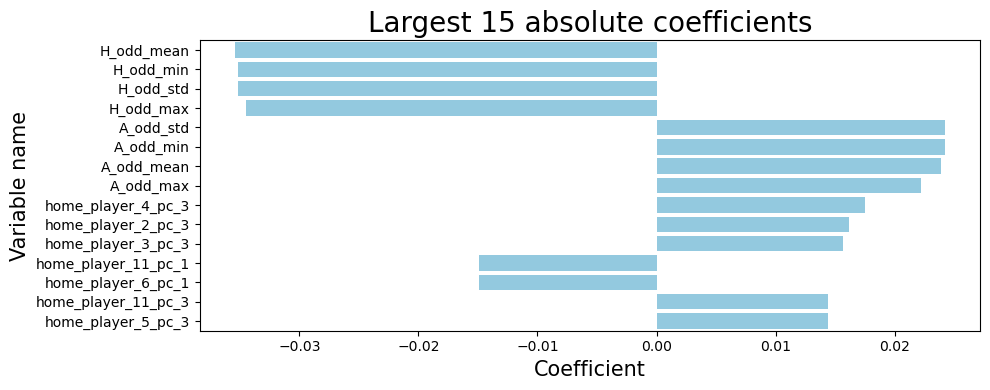

In [292]:
plt.figure(figsize = (10, 4))

sns.barplot(data = coeff.sort_values("coef_abs", ascending = False).head(15), y = "column_name", x = "coef", color = "skyblue")
plt.xlabel("Coefficient", fontsize = 15)
plt.ylabel("Variable name", fontsize = 15)
plt.title("Largest 15 absolute coefficients", fontsize = 20)



plt.tight_layout()
#plt.tick_params(axis='y', labelrotation = 90)

In [290]:
final_model.classes_

array(['away_win', 'draw', 'home_win'], dtype=object)

In [252]:
final_model.coef_[0]

array([ 4.58639051e-03,  1.64416180e-04, -7.37470346e-03,  5.85602343e-03,
        5.22732511e-05,  1.14445806e-02, -6.81104790e-03, -1.61570075e-02,
       -2.74653872e-05,  3.39756651e-03,  9.12438549e-03, -6.72223297e-03,
       -1.57005397e-02, -5.95447502e-03, -2.18409990e-04,  1.19175122e-02,
       -8.28917377e-03, -1.74837438e-02, -6.87943152e-04,  9.19974767e-04,
        1.11343826e-02, -2.08861900e-03, -1.44254208e-02,  6.92561851e-03,
        2.21392243e-04,  1.48836420e-02, -1.90580627e-03, -1.25776022e-02,
        4.04218693e-03, -1.32652446e-03,  1.25652075e-02,  1.58445648e-03,
       -1.15638518e-02,  6.69198033e-03,  1.83026974e-03,  1.31121709e-02,
        5.69867605e-03, -1.08711710e-02,  6.16623820e-03, -7.43197305e-03,
        1.02578994e-02,  4.36209031e-03, -9.49600062e-03,  6.12060291e-03,
        4.08790228e-03,  1.26051847e-02,  5.60359804e-04, -1.30959946e-02,
        1.22252778e-03,  1.44173425e-03,  1.49340036e-02, -7.93435861e-04,
       -1.44362369e-02, -

In [249]:
import shap

SystemError: initialization of _internal failed without raising an exception

In [ ]:
explainer = shap.Explainer(final_model, X_all_train_std, feature_names = X_all_train.columns)


In [ ]:
shap_values = explainer(X_all_test_std)


In [ ]:
shap.plots.beeswarm(shap_values)
#, X_test_array, feature_names=vectorizer.get_feature_names())
